In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
import os
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator

In [3]:
# --- Environment Setup ---
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['JOBLIB_LOKY_BACKEND'] = 'threading'
plt.style.use('ggplot')

In [7]:
file_path = 'Mall_Customers.csv'
df = pd.read_csv(file_path)
X = df[['Annual Income (k$)', 'Spending Score (1-100)']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Using min_samples = 4
eps = 0.3677


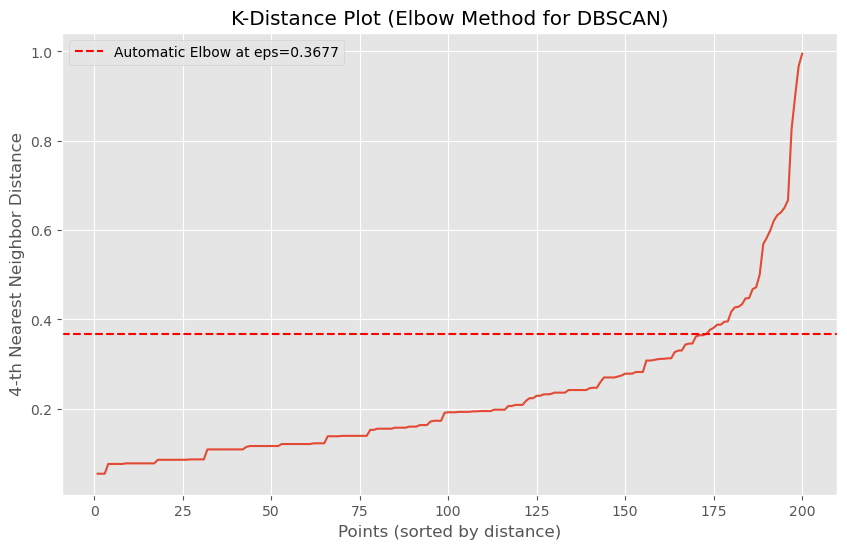

In [13]:
# ---  Find Optimal Epsilon (eps) ---

min_samples = 2 * X_scaled.shape[1] 
print(f"Using min_samples = {min_samples}")

# Calculate distance for each point to its k-th nearest neighbor
nbrs = NearestNeighbors(n_neighbors=min_samples).fit(X_scaled)
distances, indices = nbrs.kneighbors(X_scaled)

# Sort the k-th distances
distances_sorted = np.sort(distances[:, min_samples - 1])
x_range = range(1, len(distances_sorted) + 1)

kneedle = KneeLocator(
    x_range, 
    distances_sorted, 
    curve='convex', 
    direction='increasing'
)
eps_auto = kneedle.elbow_y 

if eps_auto is None:
    eps_auto = 0.3
else:
    print(f"eps = {eps_auto:.4f}")

# Plot the k-distance graph
plt.figure(figsize=(10, 6))
plt.plot(x_range, distances_sorted)
plt.title('K-Distance Plot (Elbow Method for DBSCAN)')
plt.xlabel('Points (sorted by distance)')
plt.ylabel(f'{min_samples}-th Nearest Neighbor Distance')
plt.grid(True)

# Draw the line at the automatically found elbow
plt.axhline(y=eps_auto, c='red', linestyle='--', label=f'Automatic Elbow at eps={eps_auto:.4f}')
plt.legend()


Estimated number of clusters: 3
Estimated number of noise points: 15


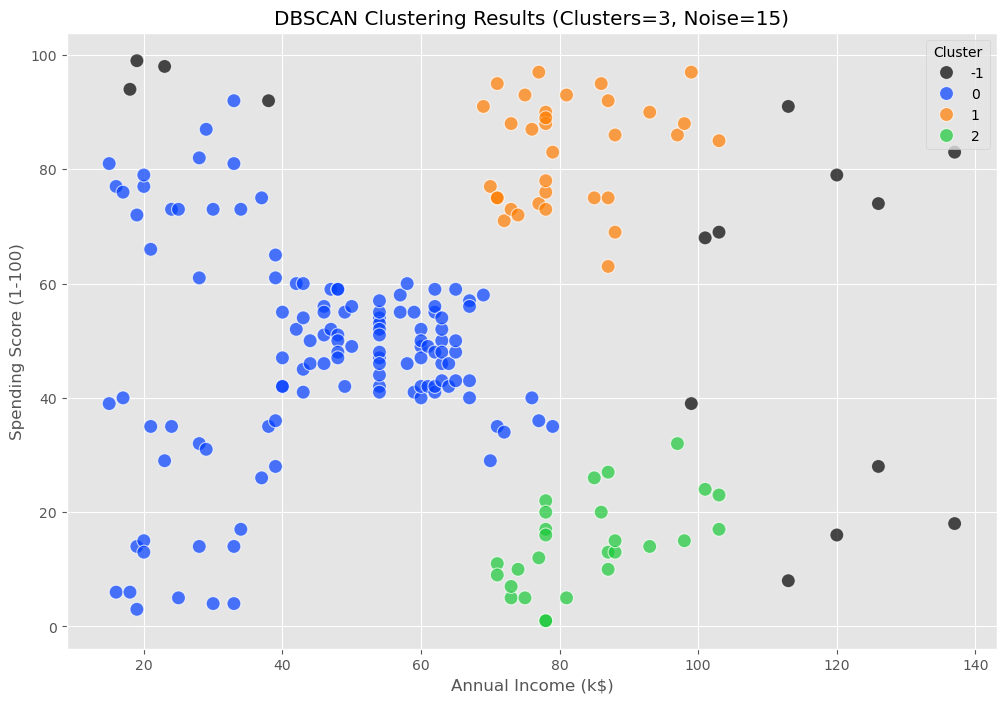

In [15]:
# --- DBSCAN Clustering Results ---

db = DBSCAN(eps=eps_auto, min_samples=min_samples)
y_db = db.fit_predict(X_scaled)

df['DBSCAN_Cluster'] = y_db
unique_labels = np.unique(y_db)
n_clusters_ = len(unique_labels) - (1 if -1 in unique_labels else 0)
n_noise_ = list(y_db).count(-1)

print(f'Estimated number of clusters: {n_clusters_}')
print(f'Estimated number of noise points: {n_noise_}')


plt.figure(figsize=(12, 8))

# Create a custom palette
cluster_colors = sns.color_palette('bright', n_colors=n_clusters_)
palette = {label: color for label, color in zip(range(n_clusters_), cluster_colors)}
palette[-1] = (0, 0, 0, 1) # Black for noise

sns.scatterplot(
    data=df,
    x='Annual Income (k$)',
    y='Spending Score (1-100)',
    hue='DBSCAN_Cluster',
    palette=palette,
    s=100,
    alpha=0.7,
    legend='full'
)

plt.title(f'DBSCAN Clustering Results (Clusters={n_clusters_}, Noise={n_noise_})')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend(title='Cluster')
plt.grid(True)